In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import math
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
plt.style.use('seaborn')
%matplotlib inline


In [2]:
def get_calibration_temperature(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_temp = h5_file[calibration_path].attrs['ftir_temperature']
        return cal_temp
    
def get_insertion_temperature(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_temp = h5_file[insertion_path].attrs['ftir_temp']
        return ins_temp
    
def get_visible_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum'][:]
        return cal
    
def get_ftir_white_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['white_spectrum2'][:]
        return cal
    
def get_visible_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec1_wavelengths_vector'][:]
        return waves
    
def get_ftir_wavelength_vector(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        waves = h5_file[calibration_path].attrs['spec2_wavelengths_vector'][:]
        return waves
    
def get_ftir_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer2/derived/absorbances'][:]
        return ins_abs
    
def get_ftir_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer2/spectra'][:]
        return ins_raw
    
def get_ftir_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer2/timestamps'][:]
        return timestamps
    
def get_visible_insertion_timestamps(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        timestamps = h5_file[f'{insertion_path}/spectrometer1/timestamps'][:]
        return timestamps
    
def get_visible_insertion_absorbances(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_abs = h5_file[f'{insertion_path}/spectrometer1/derived/absorbances'][:]
        return ins_abs
    
def get_visible_insertion_raw_spectra(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_raw = h5_file[f'{insertion_path}/spectrometer1/spectra'][:]
        return ins_raw
    
def create_list_of_items_in_node(item_type, file, node):
    with h5py.File(file, 'r') as h5_file:
        keys = []
        if item_type == "group":
            my_type = h5py._hl.group.Group
        if item_type == "dataset":
            my_type = h5py._hl.dataset.Dataset
        h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
        return keys

def create_list_of_calibrations_in_node(file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(node + '/' + group)
    return calibrations

def create_list_of_insertions_in_calibration(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        insertion_keys = list(h5_file[calibration_path].keys())
        insertions = [f'{calibration_path}/{key}' for key in insertion_keys]            
        return insertions
    
def select_by_depth_range(df, range_start, range_end):
    df_out = df.loc[(df['depth'] > range_start) & (df['depth'] < range_end)]
    return df_out

def calculate_absorbance_from_raw(raw_spectrum, white_spectrum, dark_spectrum):
    reflectance = ((raw_spectrum - dark_spectrum) / (white_spectrum - dark_spectrum))
    inverse_reflectance = 1/reflectance
    absorbance = np.log10(inverse_reflectance.astype(np.float64))
    return absorbance

def calculate_absorbance_for_2D_array(array, white_spectrum, dark_spectrum):
    absorbance_array = np.empty_like(array, dtype=np.float64)
    for i in range(array.shape[0]):
        absorbance_spectrum = calculate_absorbance_from_raw(array[i, :], white_spectrum, dark_spectrum)
        absorbance_array[i, :] = absorbance_spectrum
    return absorbance_array

def construct_full_file_path(data_path, file_name):
    file_path = data_path + file_name
    return file_path

def create_list_of_sessions_in_file(file_name):
    sessions = []
    all_groups = create_list_of_items_in_node("group", file_name, "/")
    for group in all_groups:
        if (group[0:3] == 'ses') and (len(group) == 10):
            sessions.append(group)
    return sessions

def create_list_of_insertions_in_file(file_name):
    insertions = []
    sessions = create_list_of_sessions_in_file(file_name)
    for session in sessions:
        calibrations = create_list_of_calibrations_in_node(file_name, session)
        for calibration in calibrations:
            cal_insertions = create_list_of_insertions_in_calibration(file_name, calibration)
            for insertion in cal_insertions:
                insertions.append(insertion)
    return insertions
            
def get_insertion_timestamp(file, insertion_path):
    with h5py.File(file, 'r') as h5_file:
        ins_time = h5_file[insertion_path].attrs['start_time']
        ins_timestamp = pd.Timestamp(ins_time, unit='us')
        return ins_timestamp
    
def get_calibration_timestamp(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal_time = h5_file[calibration_path].attrs['calibration_start_time']
        cal_timestamp = pd.Timestamp(cal_time, unit='us')
        return cal_timestamp  
    
def find_position_in_wavelength_vector(wavelength_vector, integer):
    position = np.where(np.isclose(wavelength_vector, integer, 1e-3))[0][0]
    return position

def normalize(value, max_value, min_value):
    normalized_value = (value - min_value)/(max_value - min_value)
    return normalized_value

def get_ftir_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum2'][:]
        return cal
    
def get_visible_dark_calibration_curve(file, calibration_path):
    with h5py.File(file, 'r') as h5_file:
        cal = h5_file[calibration_path].attrs['dark_spectrum'][:]
        return cal
        
def get_ftir_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer2/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def get_visible_spectrum_timestamp(file, insertion_path, index):
    with h5py.File(file, 'r') as h5_file:
        time = h5_file[f'{insertion_path}/spectrometer1/timestamps'][index]
        timestamp = pd.Timestamp(time, unit='us')
        return timestamp
    
def compute_3D_distance(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)
    return distance

def calculate_wavenumbers_from_wavelengths(wavelength_vector):
    return 10000000/wavelength_vector

def put_spectrum_in_wavenum_order(spectrum):
    return np.flip(spectrum)

In [3]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/All_green_files.csv')

In [4]:
vis_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]    
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        vis_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

for cal in vis_cals:
    print(cal[0], cal[1], cal[2], cal[3])

210401_tests/vis_ftir_test1.h5 4/1/21 session001 cal001
210401_tests/vis_ftir_test1.h5 4/1/21 session001 cal002
210402_SOC_canister/tests_210402.h5 4/2/21 session002 cal001
210407_test_in_yard_and_canisters/soc_210407.h5 4/7/21 session001 cal001
210409_stationary_moving/blank_210409.h5 4/9/21 session003 cal001
210409_stationary_moving/blank_210409.h5 4/9/21 session003 cal002
210413_BNP_transect/BNP_data_collection_210413.h5 4/13/21 session001 cal001
210413_BNP_transect/BNP_data_collection_210413.h5 4/13/21 session002 cal001
210414_BNP_transect2/BNP_data_collection_210414.h5 4/14/21 session001 cal001
210414_BNP_transect2/BNP_data_collection_210414.h5 4/14/21 session001 cal002
210414_BNP_transect2/BNP_data_collection_210414.h5 4/14/21 session001 cal003
210414_BNP_transect2/BNP_data_collection_210414.h5 4/14/21 session001 cal004
210414_BNP_transect2/BNP_data_collection_210414.h5 4/14/21 session002 cal001
210414_BNP_transect2/BNP_data_collection_210414.h5 4/14/21 session002 cal002
210414_B

In [5]:
vis_cals_df = pd.DataFrame(data=vis_cals, columns=['file_name', 'date', 'session', 'calibration'])

In [6]:
vis_cals_df

,file_name,date,session,calibration
0,210401_tests/vis_ftir_test1.h5,4/1/21,session001,cal001
1,210401_tests/vis_ftir_test1.h5,4/1/21,session001,cal002
2,210402_SOC_canister/tests_210402.h5,4/2/21,session002,cal001
3,210407_test_in_yard_and_canisters/soc_210407.h5,4/7/21,session001,cal001
4,210409_stationary_moving/blank_210409.h5,4/9/21,session003,cal001
...,...,...,...,...
104,210430_green_tests/green_testing_210430.h5,4/30/21,session003,cal002
105,210430_green_tests/green_testing_210430.h5,4/30/21,session003,cal003
106,210502_green_tests/green_testing_210502.h5,5/2/21,session001,cal001
107,210502_green_tests/green_testing_210502.h5,5/2/21,session001,cal002


In [7]:
vis_cals_df.to_csv('data/ftir_calibrations.csv')

In [8]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"
df = pd.read_csv('data/All_nirone_files.csv')

nirone_cals = []
for index in df.index.values:
    file_name = df['file_name'][index]
    file = path_name + file_name
    date = df['date'][index]    
    calibrations = create_list_of_calibrations_in_node(file, "/")
    for calibration in calibrations:
        nirone_cals.append((file_name, date, calibration[2:12], calibration[-6:]))

for cal in nirone_cals:
    print(cal[0], cal[1], cal[2], cal[3])

210331_nirone_tests/nirone_test4.h5 3/31/21 session003 cal001
210331_nirone_tests/nirone_test4.h5 3/31/21 session003 cal002
210401_tests/next2/more_nirone_test1.h5 4/1/21 session002 cal001
210401_tests/next2/more_nirone_test1.h5 4/1/21 session003 cal001
210401_tests/next2/more_nirone_test1.h5 4/1/21 session004 cal001
210407_test_in_yard_and_canisters/nirone_210407.h5 4/7/21 session002 cal001
210407_test_in_yard_and_canisters/nirone_210407.h5 4/7/21 session002 cal002
210409_stationary_moving/blank2_210409.h5 4/9/21 session001 cal001
210410_nirone_vibration/nirone_vibration_210410.h5 4/10/21 session001 cal001
210410_nirone_vibration/nirone_vibration_210410.h5 4/10/21 session001 cal002
210415_nirone_tests/nirone_testing_210415.h5 4/15/21 session001 cal001
210415_nirone_tests/nirone_testing_210415.h5 4/15/21 session001 cal002
210415_nirone_tests/nirone_testing_210415.h5 4/15/21 session001 cal003
210415_nirone_tests/nirone_testing_210415.h5 4/15/21 session002 cal001
210415_nirone_tests/niro

In [9]:
nirone_cals_df = pd.DataFrame(data=nirone_cals, columns=['file_name', 'date', 'session', 'calibration'])

In [10]:
nirone_cals_df.to_csv('data/nirone_calibrations.csv')

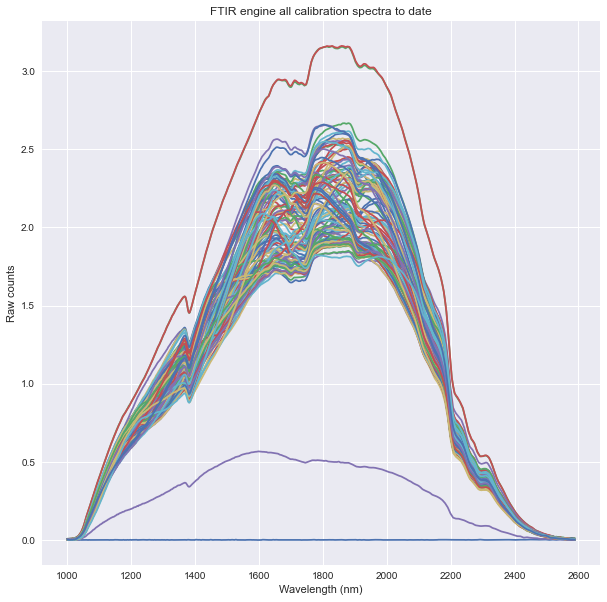

In [11]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("FTIR engine all calibration spectra to date")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    ftir_waves = get_ftir_wavelength_vector(file, cal_path)
    ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
    ax.plot(ftir_waves, ftir_cal_spectrum)
plt.show()
plt.close()

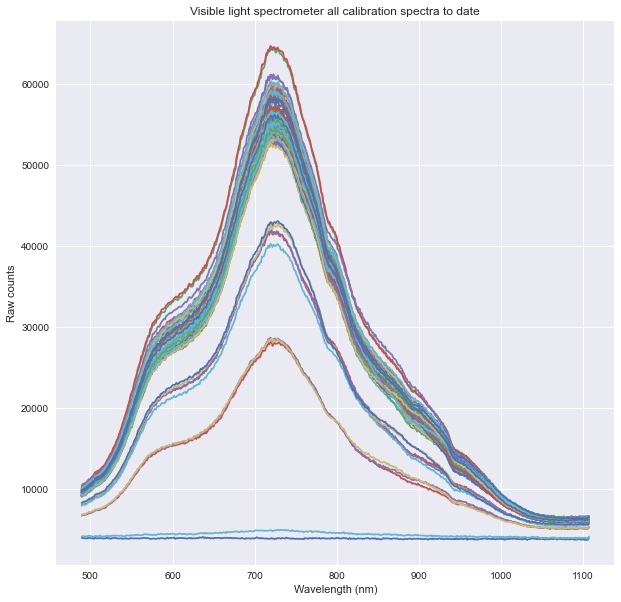

In [12]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("Visible light spectrometer all calibration spectra to date")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    vis_waves = get_visible_wavelength_vector(file, cal_path)
    vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    ax.plot(vis_waves, vis_cal_spectrum)
plt.show()
plt.close()

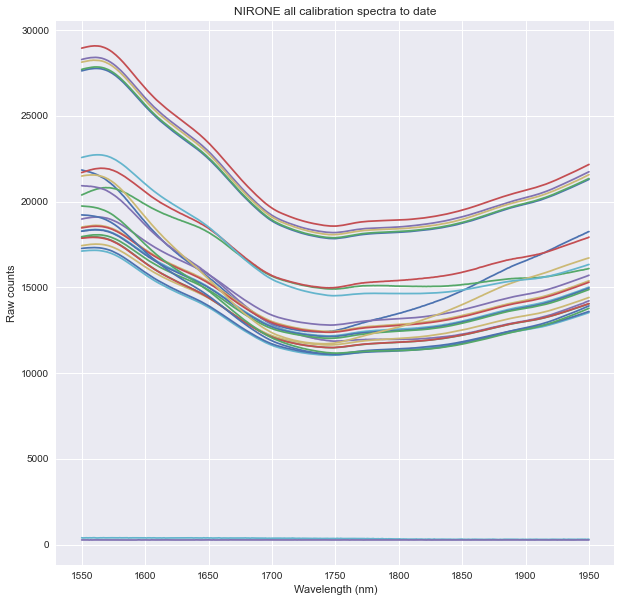

In [13]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax.set_title("NIRONE all calibration spectra to date")
ax.set_ylabel("Raw counts")
ax.set_xlabel("Wavelength (nm)")
for index in nirone_cals_df.index.values:
    file_name = nirone_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = nirone_cals_df['session'][index] + "/" + nirone_cals_df['calibration'][index]
    nirone_waves = get_visible_wavelength_vector(file, cal_path)
    nirone_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    ax.plot(nirone_waves, nirone_cal_spectrum)
plt.show()
plt.close()

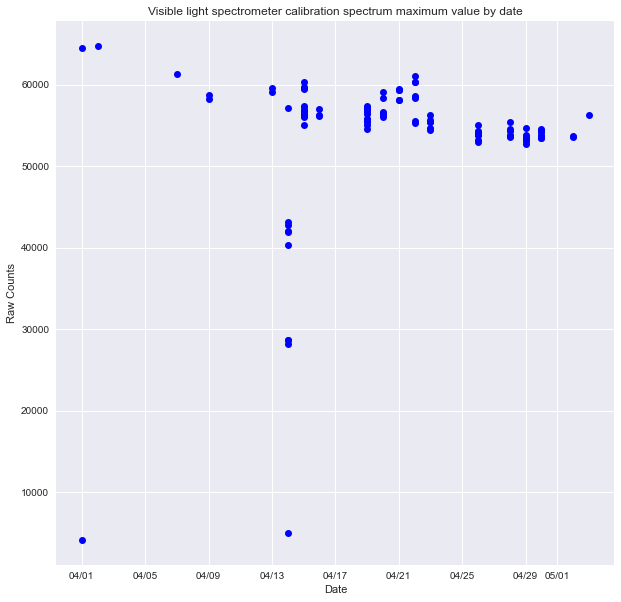

In [14]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax. set_title("Visible light spectrometer calibration spectrum maximum value by date")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    date_str = vis_cals_df['date'][index]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    vis_waves = get_visible_wavelength_vector(file, cal_path)
    vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    max_spectrum_value = vis_cal_spectrum.max()
    
    ax.plot(date, max_spectrum_value, "bo")
plt.show()
plt.close()


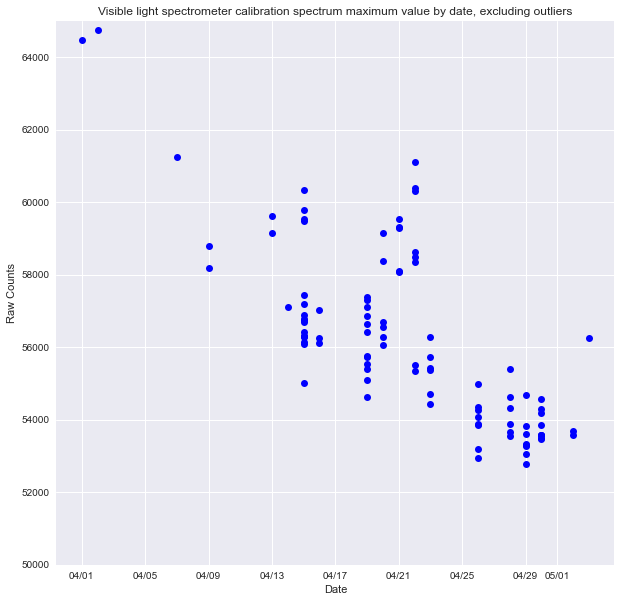

In [15]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax. set_title("Visible light spectrometer calibration spectrum maximum value by date, excluding outliers")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
ax.set_ylim(50000, 65000)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    date_str = vis_cals_df['date'][index]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    vis_waves = get_visible_wavelength_vector(file, cal_path)
    vis_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    max_spectrum_value = vis_cal_spectrum.max()
    
    ax.plot(date, max_spectrum_value, "bo")
plt.show()
plt.close()

In [16]:
date = datetime.datetime.strptime('4/1/21', '%m/%d/%y').date()

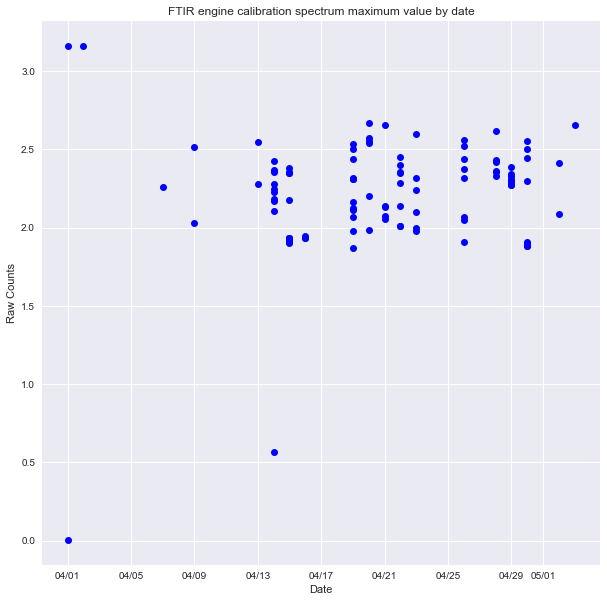

In [17]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax. set_title("FTIR engine calibration spectrum maximum value by date")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    date_str = vis_cals_df['date'][index]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    ftir_waves = get_ftir_wavelength_vector(file, cal_path)
    ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
    max_spectrum_value = ftir_cal_spectrum.max()
    
    ax.plot(date, max_spectrum_value, "bo")
plt.show()
plt.close()

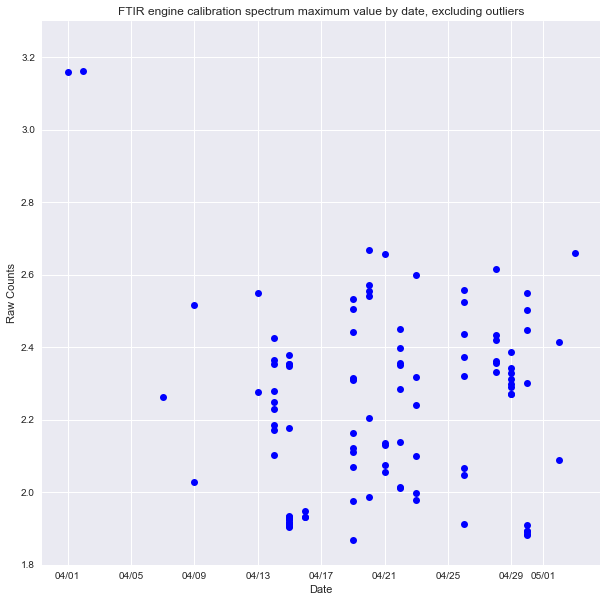

In [18]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax. set_title("FTIR engine calibration spectrum maximum value by date, excluding outliers")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
ax.set_ylim(1.8, 3.3)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

for index in vis_cals_df.index.values:
    file_name = vis_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = vis_cals_df['session'][index] + "/" + vis_cals_df['calibration'][index]
    date_str = vis_cals_df['date'][index]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    ftir_waves = get_ftir_wavelength_vector(file, cal_path)
    ftir_cal_spectrum = get_ftir_white_calibration_curve(file, cal_path)
    max_spectrum_value = ftir_cal_spectrum.max()
    
    ax.plot(date, max_spectrum_value, "bo")
plt.show()
plt.close()

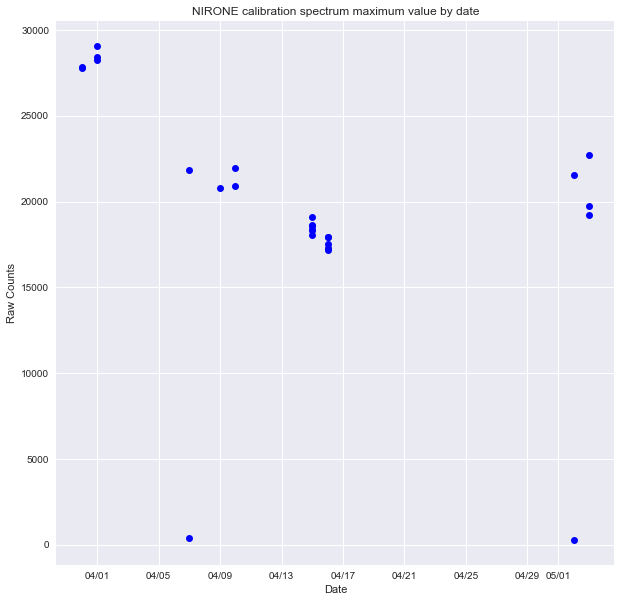

In [19]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax. set_title("NIRONE calibration spectrum maximum value by date")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
# ax.set_ylim(1.8, 3.3)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

for index in nirone_cals_df.index.values:
    file_name = nirone_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = nirone_cals_df['session'][index] + "/" + nirone_cals_df['calibration'][index]
    date_str = nirone_cals_df['date'][index]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    nirone_waves = get_visible_wavelength_vector(file, cal_path)
    nirone_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    max_spectrum_value = nirone_cal_spectrum.max()
    
    ax.plot(date, max_spectrum_value, "bo")
plt.show()
plt.close()

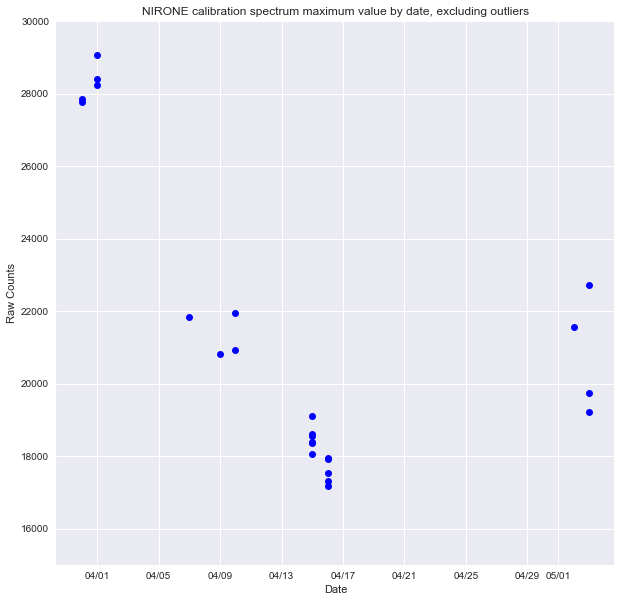

In [20]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax. set_title("NIRONE calibration spectrum maximum value by date, excluding outliers")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
ax.set_ylim(15000, 30000)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

for index in nirone_cals_df.index.values:
    file_name = nirone_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = nirone_cals_df['session'][index] + "/" + nirone_cals_df['calibration'][index]
    date_str = nirone_cals_df['date'][index]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    nirone_waves = get_visible_wavelength_vector(file, cal_path)
    nirone_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    max_spectrum_value = nirone_cal_spectrum.max()
    
    ax.plot(date, max_spectrum_value, "bo")
plt.show()
plt.close()

In [21]:
np.where(nirone_waves == 1750)[0][0]

200

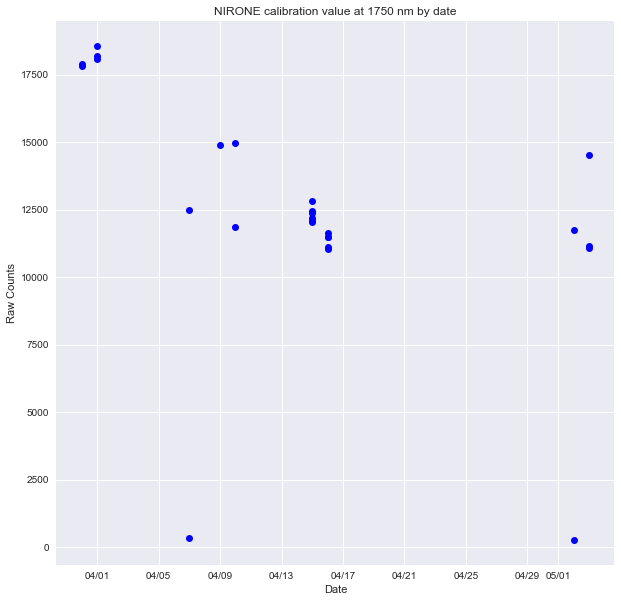

In [22]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax. set_title("NIRONE calibration value at 1750 nm by date")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
# ax.set_ylim(1.8, 3.3)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

for index in nirone_cals_df.index.values:
    file_name = nirone_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = nirone_cals_df['session'][index] + "/" + nirone_cals_df['calibration'][index]
    date_str = nirone_cals_df['date'][index]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    nirone_waves = get_visible_wavelength_vector(file, cal_path)
    wave_index_1750 = np.where(nirone_waves == 1750)[0][0]
    nirone_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    spectrum_value_at_1750 = nirone_cal_spectrum[wave_index_1750]
    
    ax.plot(date, spectrum_value_at_1750, "bo")
plt.show()
plt.close()

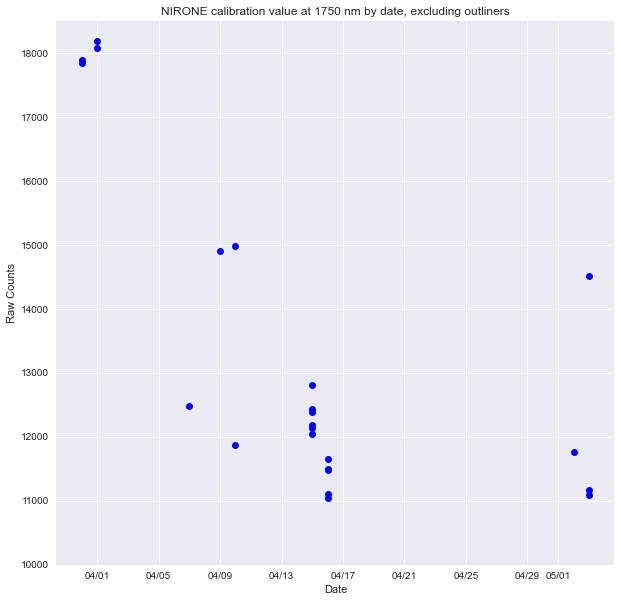

In [23]:
path_name = "/Users/linda/OneDrive/Documents/S4_mine_p/Projects/Data_collected/"

fig, ax = plt.subplots(figsize=(10,10))
ax. set_title("NIRONE calibration value at 1750 nm by date, excluding outliners")
ax.set_xlabel("Date")
ax.set_ylabel("Raw Counts")
ax.set_ylim(10000, 18500)
date_form = DateFormatter("%m/%d")
ax.xaxis.set_major_formatter(date_form)

for index in nirone_cals_df.index.values:
    file_name = nirone_cals_df['file_name'][index]
    file = path_name + file_name
    cal_path = nirone_cals_df['session'][index] + "/" + nirone_cals_df['calibration'][index]
    date_str = nirone_cals_df['date'][index]
    date = datetime.datetime.strptime(date_str, '%m/%d/%y').date()
    
    nirone_waves = get_visible_wavelength_vector(file, cal_path)
    wave_index_1750 = np.where(nirone_waves == 1750)[0][0]
    nirone_cal_spectrum = get_visible_white_calibration_curve(file, cal_path)
    spectrum_value_at_1750 = nirone_cal_spectrum[wave_index_1750]
    
    ax.plot(date, spectrum_value_at_1750, "bo")
plt.show()
plt.close()